### Khai báo

In [1]:
# import cv2
# import gc
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from PIL import Image
# from glob import glob
 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, roc_curve, auc
# from sklearn import metrics

# import tensorflow as tf
# from keras import layers
# from tensorflow import keras
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras import regularizers, optimizers

# from keras.applications import ResNet50
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras.optimizers import Adam
# from tensorflow.keras.layers import Attention

# import warnings
# warnings.filterwarnings('ignore')

import cv2
import gc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn import metrics

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers

from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.layers import Attention

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile

### Tải tệp dữ liệu

In [2]:
from zipfile import ZipFile
 
data_path = 'D:\Lung_Cancer_Detection\lung_cancer_image.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [3]:
path = r'D:\Lung_Cancer_Detection\train'
classes = os.listdir(path)
classes

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

### EDA

In [ ]:
data_dir = r"D:\Lung_Cancer_Detection\train"
classes = os.listdir(data_dir)

# Hàm hiển thị một số hình ảnh mẫu từ mỗi lớp
def display_sample_images(data_dir, classes, num_samples = 3):
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        img_files = os.listdir(cls_dir)
        sample_images = np.random.choice(img_files, num_samples, replace = False)
        plt.figure(figsize = (30, 5))
        for i, img_file in enumerate(sample_images):
            img_path = os.path.join(cls_dir, img_file)
            img = image.load_img(img_path, target_size = (224, 224))  # Chỉnh kích thước hình ảnh nếu cần thiết
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
        plt.show()

# Hiển thị một số hình ảnh mẫu từ mỗi lớp
display_sample_images(data_dir, classes)

# Hàm phân tích phân phối của dữ liệu đầu vào
def analyze_class_distribution(data_dir, classes):
    class_counts = {}
    bar_positions = range(len(classes))  
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        num_images = len(os.listdir(cls_dir))
        class_counts[cls] = num_images
    plt.bar(bar_positions, class_counts.values())  
#     plt.xlabel('Classes')
    plt.ylabel('Số lượng hình ảnh')
    plt.title('Class Distribution')
    plt.xticks([pos for pos in bar_positions], class_counts.keys(), rotation = 15, ha = 'right')  
    plt.tight_layout()
    plt.show()
analyze_class_distribution(data_dir, classes)

# Hàm phân tích kích thước hình ảnh
def analyze_image_sizes(data_dir, classes):
    image_sizes = []
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        img_files = os.listdir(cls_dir)
        for img_file in img_files:
            img_path = os.path.join(cls_dir, img_file)
            img = image.load_img(img_path)
            width, height = img.size
            image_sizes.append((width, height))
    image_sizes = np.array(image_sizes)
    plt.scatter(image_sizes[:, 0], image_sizes[:, 1])
    plt.xlabel('Chiều rộng')
    plt.ylabel('Chiều cao')
    plt.title('Kích thước ảnh')
    plt.show()

# Phân tích kích thước của hình ảnh
analyze_image_sizes(data_dir, classes)

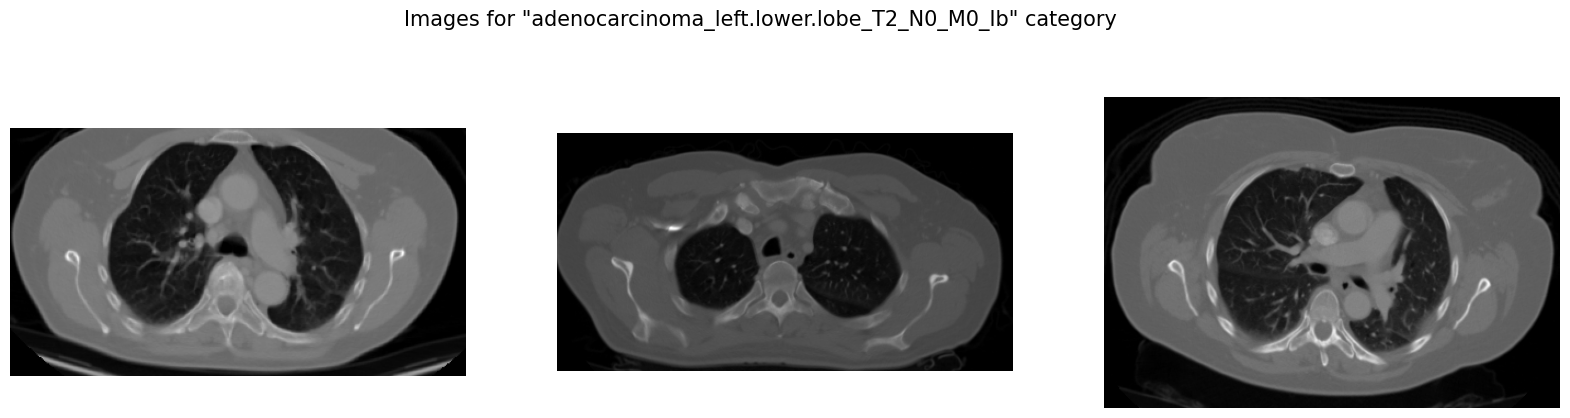

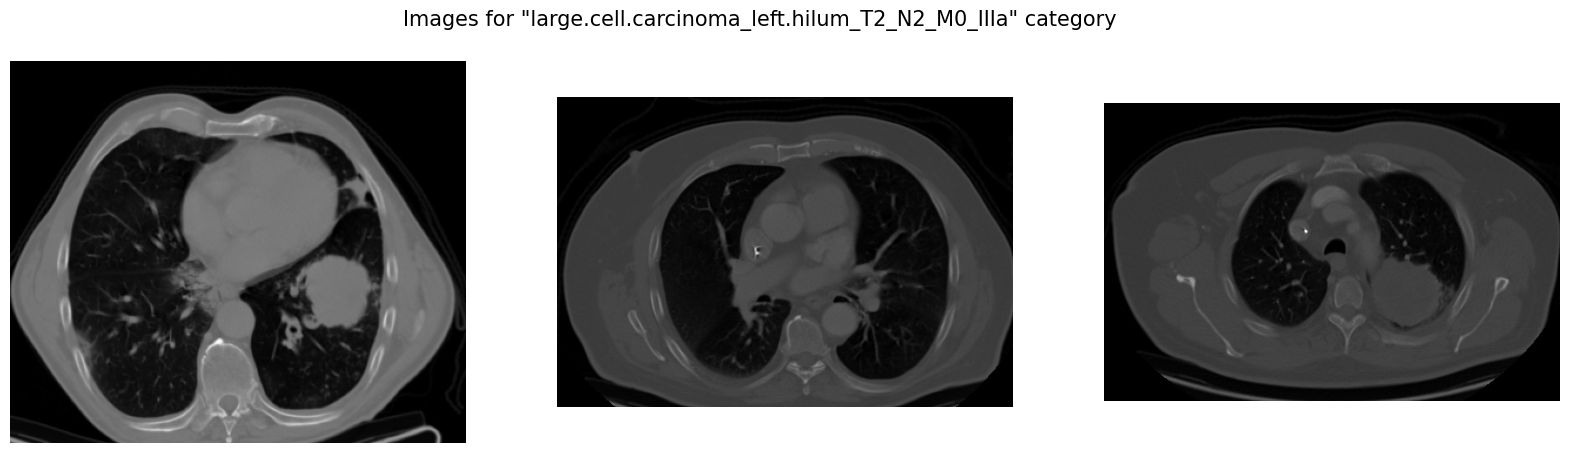

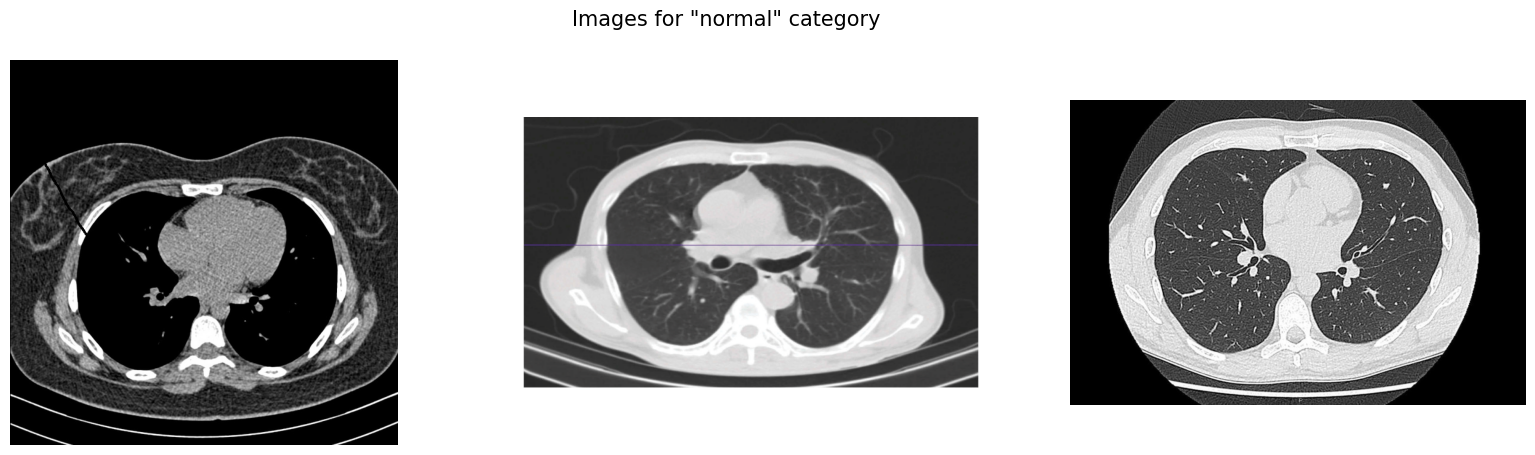

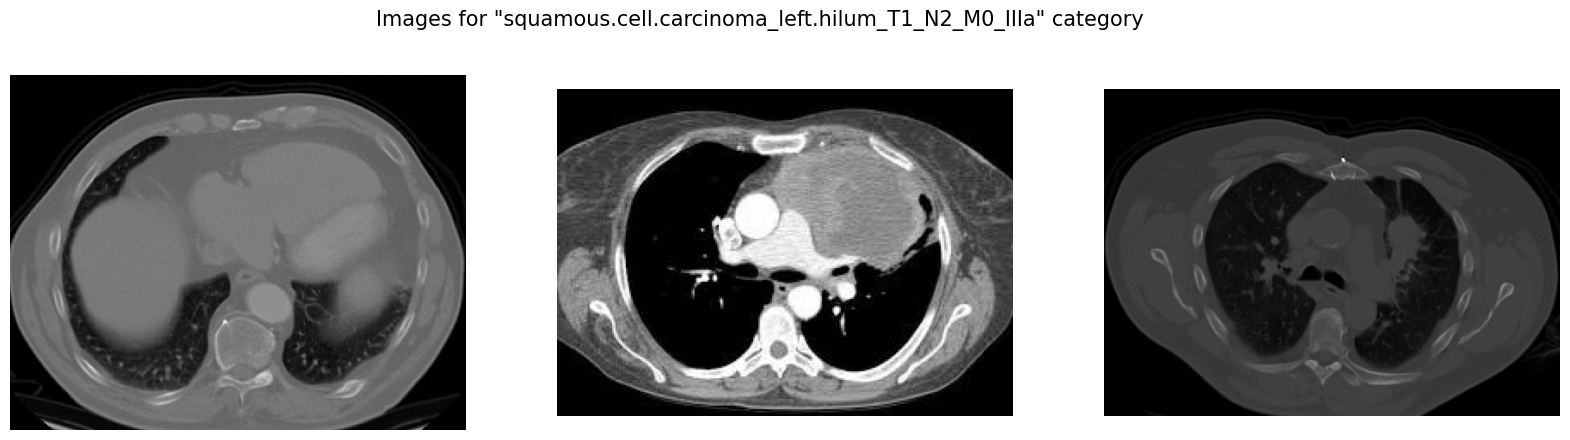

In [4]:
path = r'D:\Lung_Cancer_Detection\train'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    fig.suptitle(f'Images for "{cat}" category', fontsize = 15)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

### Tiền xử lý dữ liệu 

In [ ]:
def preprocess_image(img_path, target_size=(256, 256)):
    # Đọc hình ảnh từ đường dẫn
    img = cv2.imread(img_path)
    
    # Chỉnh kích thước hình ảnh về kích thước mục tiêu
    img = cv2.resize(img, target_size)
    
    # Chuẩn hóa dữ liệu pixel vào khoảng [0, 1]
    img = img.astype('float32') / 255.0
    
    return img

def data_augmentation(images):
    # Tăng cường dữ liệu: Xoay ảnh ngẫu nhiên
    augmented_images = []
    for img in images:
        angle = np.random.randint(-10, 10)  # Góc xoay ngẫu nhiên trong khoảng [-10, 10] độ
        rows, cols = img.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated_img = cv2.warpAffine(img, M, (cols, rows))
        augmented_images.append(rotated_img)
    
    return augmented_images

def apply_contrast_stretching(images):
    # Mở rộng độ tương phản của hình ảnh
    stretched_images = []
    for img in images:
        p2, p98 = np.percentile(img, (2, 98))
        img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
        stretched_images.append(img_rescale)
    
    return stretched_images

def apply_gaussian_blur(images):
    # Áp dụng lọc Gaussian để giảm nhiễu
    blurred_images = []
    for img in images:
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        blurred_images.append(blurred_img)
    
    return blurred_images

### Chuẩn bị dữ liệu

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.png')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_test, Y_train, Y_test = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2024)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = SPLIT, random_state = 2024)
print(X_train.shape, X_val.shape, X_test.shape)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2024)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = SPLIT, random_state = 2024)
print(X_train.shape, X_val.shape, X_test.shape)

(480, 256, 256, 3) (96, 256, 256, 3) (25, 256, 256, 3)


### Xây dựng mô hình 

In [7]:
model = keras.models.Sequential([
    layers.Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 3), padding = 'same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(4, activation = 'softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,420 (128.50 MB)

 Trainable params: 33,683,652 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

### Huấn luyện mô hình 

In [8]:
checkpointer = ModelCheckpoint('huanluyenmohinh.keras', verbose = 1, save_best_only = True)
optimizer = optimizers.Adam(learning_rate = 0.00001, decay = 1e-5)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])
history = model.fit(X_train, Y_train,
                    epochs = 100,
                    verbose = 1,
                    validation_data = (X_val, Y_val),
                    callbacks = [checkpointer])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - acc: 0.3828 - loss: 1.5315
Epoch 1: val_loss improved from inf to 6.36969, saving model to huanluyenmohinh.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 124s 8s/step - acc: 0.3880 - loss: 1.5165 - val_acc: 0.2812 - val_loss: 6.3697
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.7481 - loss: 0.6961
Epoch 2: val_loss improved from 6.36969 to 1.96154, saving model to huanluyenmohinh.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - acc: 0.7477 - loss: 0.6949 - val_acc: 0.5000 - val_loss: 1.9615
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.8141 - loss: 0.4957
Epoch 3: val_loss improved from 1.96154 to 1.42825, saving model to huanluyenmohinh.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - acc: 0.8133 - loss: 0.4963 - val_acc: 0.5833 - val_loss: 1.4282
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.8967 - loss: 0.3426
Epoch 4: val_loss improved from 1.42825 to 1.10257, saving model to huanluyenmohinh.keras
15/15 ━━━━━━

### Kết quả huấn luyện

In [ ]:
model.load_weights('huanluyenmohinh.keras')
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

In [11]:
# print(metrics.classification_report(Y_val, Y_pred, target_names = classes))
Y_pred = model.predict(X_val)
Y_val = np.squeeze(Y_val)
Y_pred = np.argmax(Y_pred, axis = 1)

Y_val_integer = np.argmax(Y_val, axis = 1)  
print(metrics.classification_report(Y_val_integer, Y_pred, target_names = classes))

Y_val_integer = np.argmax(Y_val, axis = 1)
f1 = f1_score(Y_val_integer, Y_pred, average = 'weighted')

print("F1 score:", f1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 581ms/step
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.84      0.91      0.87        34
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.91      0.83      0.87        12
                                          normal       0.96      1.00      0.98        27
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.95      0.83      0.88        23

                                        accuracy                           0.91        96
                                       macro avg       0.92      0.89      0.90        96
                                    weighted avg       0.91      0.91      0.91        96

F1 score: 0.9058291224813108


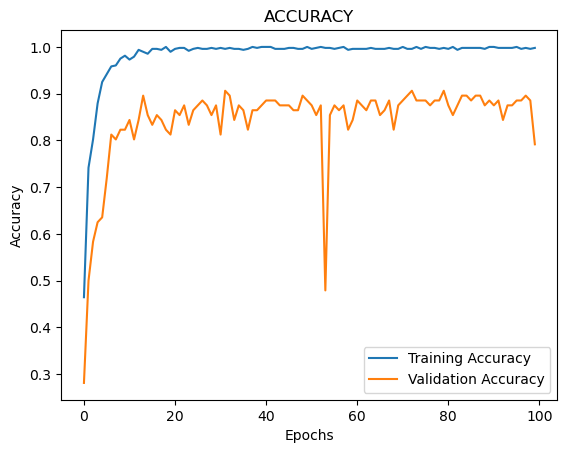

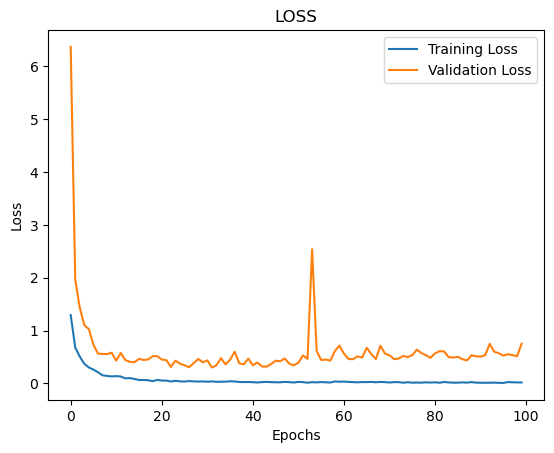

In [12]:
plt.plot(history.history['acc'], label = 'Training Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation Accuracy')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

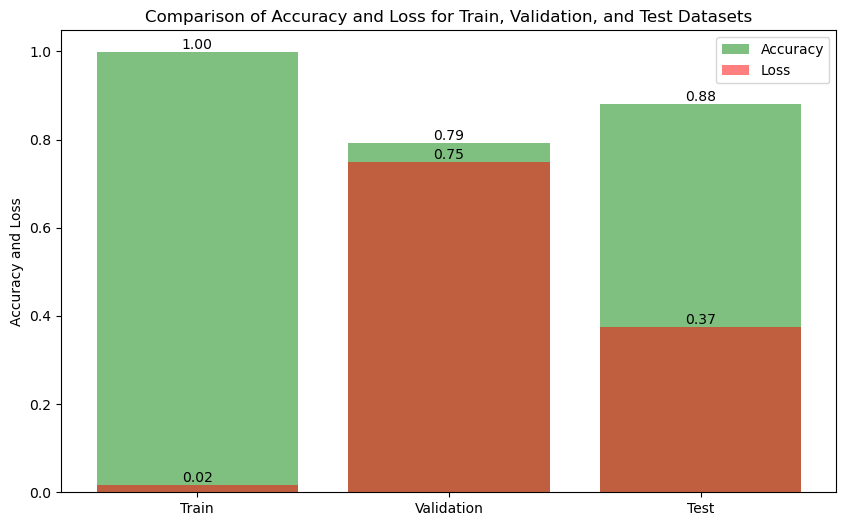

In [13]:
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
test_accuracy = model.evaluate(X_test, Y_test, verbose = 0)[1]

train_loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = model.evaluate(X_test, Y_test, verbose = 0)[0]

datasets = ['Train', 'Validation', 'Test']

accuracy_values = [train_accuracy[-1], val_accuracy[-1], test_accuracy]
loss_values = [train_loss[-1], val_loss[-1], test_loss]

plt.figure(figsize = (10, 6))
plt.bar(datasets, accuracy_values, color = 'g', alpha = 0.5, label = 'Accuracy')
plt.bar(datasets, loss_values, color = 'r', alpha = 0.5, label = 'Loss')

for i in range(len(datasets)):
    plt.text(i, accuracy_values[i], f'{accuracy_values[i]:.2f}', ha = 'center', va = 'bottom')
    plt.text(i, loss_values[i], f'{loss_values[i]:.2f}', ha = 'center', va = 'bottom')

plt.ylabel('Accuracy and Loss')
plt.title('Comparison of Accuracy and Loss for Train, Validation, and Test Datasets')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step


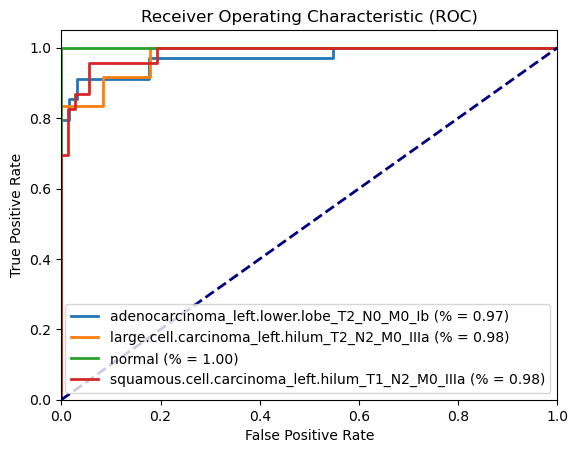

In [16]:
Y_pred_proba = model.predict(X_val)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(Y_val[:, i], Y_pred_proba[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw = 2, label = '{0} (% = {1:0.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = "lower right")  
plt.show()

### Xây dựng mô hình ResNet-50

In [17]:
base_model = ResNet50(weights = 'imagenet', include_top = False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(4, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, None, None, 3)     │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, None, None, 64)    │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 64)    │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 64)    │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 25,636,868 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
checkpointer = ModelCheckpoint('chestmodel-resnet5.keras', verbose = 1, save_best_only = True)
optimizer = optimizers.Adam(learning_rate = 0.00001, decay = 1e-5)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])
history = model.fit(X_train, Y_train,
                    epochs = 100,
                    verbose = 1,
                    validation_data = (X_val, Y_val),
                    callbacks = [checkpointer])

### Huấn luyện mô hình

In [18]:
import time
from keras.callbacks import Callback

class TimeHistory(Callback):
    def on_train_begin(self, logs = {}):
        self.times = []

    def on_epoch_begin(self, epoch, logs = {}):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs = {}):
        epoch_time = time.time() - self.epoch_start_time
        self.times.append(epoch_time)
        print(f"Epoch {epoch + 1} took {epoch_time:.2f} seconds")

time_callback = TimeHistory()
checkpointer = ModelCheckpoint('chestmodel-resnet5.keras', verbose = 1, save_best_only = True)
optimizer = optimizers.Adam(learning_rate = 0.00001, decay = 1e-5)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])
history = model.fit(X_train, Y_train,
                    epochs = 100,
                    verbose = 1,
                    validation_data = (X_val, Y_val),
                    callbacks = [checkpointer, time_callback])

total_training_time = sum(time_callback.times)
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - acc: 0.3558 - loss: 1.3988 
Epoch 1: val_loss improved from inf to 1.38741, saving model to chestmodel-resnet5.keras
Epoch 1 took 318.81 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 319s 17s/step - acc: 0.3630 - loss: 1.3890 - val_acc: 0.3750 - val_loss: 1.3874
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - acc: 0.7738 - loss: 0.8254 
Epoch 2: val_loss improved from 1.38741 to 1.25852, saving model to chestmodel-resnet5.keras
Epoch 2 took 246.59 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 247s 17s/step - acc: 0.7757 - loss: 0.8212 - val_acc: 0.4167 - val_loss: 1.2585
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - acc: 0.9056 - loss: 0.5585 
Epoch 3: val_loss improved from 1.25852 to 1.24373, saving model to chestmodel-resnet5.keras
Epoch 3 took 245.11 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 245s 16s/step - acc: 0.9066 - loss: 0.5565 - val_acc: 0.4271 - val_loss: 1.2437
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - acc: 0.9638 - loss: 0.40

### Kết quả huấn luyện

In [19]:
# Đánh giá mô hình trên dữ liệu kiểm tra
loss, accuracy = model.evaluate(X_test, Y_test, verbose = 0)
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")

Loss on test data: 0.03285848721861839
Accuracy on test data: 1.0


In [22]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

for i in range(len(train_acc)):
    print(f"Epoch {i + 1}: Training Accuracy = {train_acc[i]}, Validation Accuracy = {val_acc[i]}")

Epoch 1: Training Accuracy = 0.47083333134651184, Validation Accuracy = 0.375
Epoch 2: Training Accuracy = 0.8041666746139526, Validation Accuracy = 0.4166666567325592
Epoch 3: Training Accuracy = 0.9229166507720947, Validation Accuracy = 0.4270833432674408
Epoch 4: Training Accuracy = 0.9645833373069763, Validation Accuracy = 0.4583333432674408
Epoch 5: Training Accuracy = 0.987500011920929, Validation Accuracy = 0.46875
Epoch 6: Training Accuracy = 0.9958333373069763, Validation Accuracy = 0.4895833432674408
Epoch 7: Training Accuracy = 0.9958333373069763, Validation Accuracy = 0.4895833432674408
Epoch 8: Training Accuracy = 0.9979166388511658, Validation Accuracy = 0.5208333134651184
Epoch 9: Training Accuracy = 0.9979166388511658, Validation Accuracy = 0.5520833134651184
Epoch 10: Training Accuracy = 0.9979166388511658, Validation Accuracy = 0.6041666865348816
Epoch 11: Training Accuracy = 0.9958333373069763, Validation Accuracy = 0.6666666865348816
Epoch 12: Training Accuracy = 0.

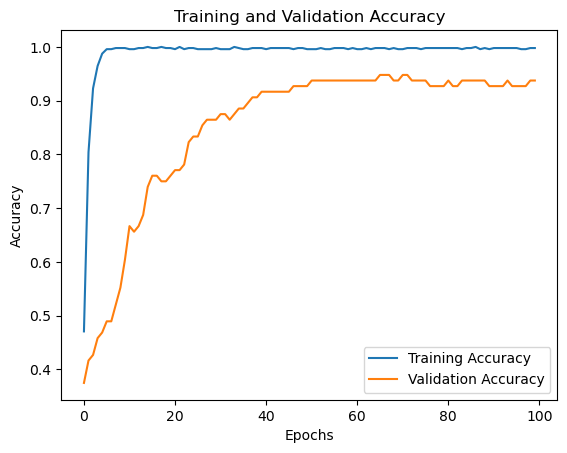

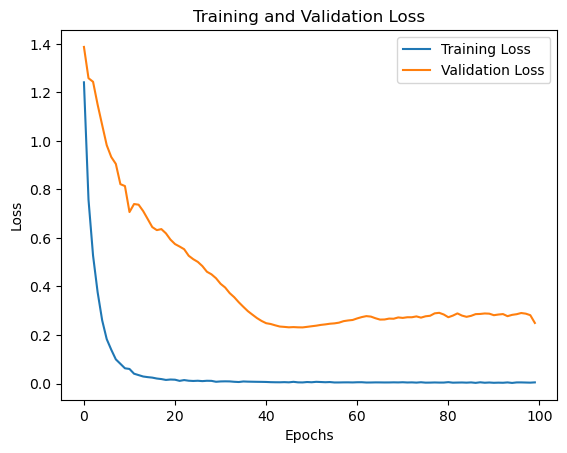

In [20]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Resnet-50 kết hợp Attention Mechanism

In [ ]:
base_model = ResNet50(weights = 'imagenet', include_top = False)
attention = Attention()([base_model.output, base_model.output])
x = GlobalAveragePooling2D()(attention)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(4, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.summary()